# Assigment solution

In [1]:
# !pip install sqlalchemy psycopg2 pandas sklearn nltk numpy boto3


# 01 data ingestion

In [2]:
import os
import pandas as pd
import numpy as np
import zipfile
import boto3
import psycopg2
import csv
from io import StringIO
from sqlalchemy import create_engine


#
# Here is some code to help you get started. This will connect to 
# s3 and retrieve earlier loans from the file area, they are 
# zipped into jsons.zip. The code will also extract the json 
# files to the /jsons folder. There is one json file per 
# load application, in total 10000 st. 
# 
# 

folder = "jsons"

if folder not in os.listdir():
    os.mkdir(folder)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket("arn:aws:s3:eu-north-1:705545259095:accesspoint/bizware")
    parsed = []

    for obj in bucket.objects.all():
        bucket.download_file(obj.key, obj.key)
        print(f"downloaded {obj.key}")
        if ".zip" in obj.key:
            with zipfile.ZipFile(obj.key, 'r') as zip_ref:
                zip_ref.extractall()
                print(f"extracted {obj.key}")

# now the task is to parse the json files and collect 
# them into a pandas df. 

# useful functions here is 
# os.listdir("mapp") # list all files in the folder 
#     called "mapp" located in the current working directory
#
# pd.read_json(file) parse a json file
# 
# pd.DataFrame(list_of_series) # try to create a 
#     dataframe from a list of pandas series
# 



### Print random json file

In [3]:
random_json_file = os.listdir(folder)[123]
json_path = os.path.join(folder, random_json_file)
pd.read_json(json_path, typ="series")


id                                 34051894
loan_amnt                             30000
term                              36 months
emp_title             Senior Vice President
emp_length                        10+ years
home_ownership                     MORTGAGE
annual_inc                           200000
loan_status                      Fully Paid
desc                                   None
purpose                  debt_consolidation
title                    Debt consolidation
addr_state                               NC
nr_payment_remarks                        0
nr_loans                                 19
dtype: object

## solution to data ingestion

In [4]:
#------------------------------
#-------
                
files = os.listdir(folder)
parsed = []
for i, file in enumerate(files):
    with open(f"{folder}/{file}") as f:
        parsed.append(pd.read_json(f, typ="series"))
    
    if (i > 0) & (i % 1000 == 0):
        print(f"{i} files parsed")


df = pd.DataFrame(parsed)
print(df.shape[0], " rows in dataset")

1000 files parsed
2000 files parsed
3000 files parsed
4000 files parsed
5000 files parsed
6000 files parsed
7000 files parsed
8000 files parsed
9000 files parsed
10000  rows in dataset


In [5]:
df.head()

,id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,loan_status,desc,purpose,title,addr_state,nr_payment_remarks,nr_loans
0,970906,14400.0,36 months,covanta energy,3 years,MORTGAGE,75000.0,Fully Paid,Borrower added on 10/27/11 > purchace new ai...,major_purchase,personal,VA,0.0,19.0
1,634792,15800.0,36 months,None,10+ years,MORTGAGE,36000.0,Fully Paid,Borrower added on 12/20/10 > renovations and...,home_improvement,dukeberbatim,IL,0.0,7.0
2,16371827,12000.0,36 months,Sales Engineer,3 years,RENT,88000.0,Fully Paid,None,debt_consolidation,Debt consolidation,FL,0.0,31.0
3,45644356,32000.0,60 months,IT Manager,2 years,MORTGAGE,125000.0,Fully Paid,None,credit_card,Credit card refinancing,NJ,0.0,47.0
4,11946125,6000.0,36 months,store manager,10+ years,RENT,53000.0,Fully Paid,None,credit_card,Credit card refinancing,CA,0.0,23.0


# 02 data cleaning

In [6]:
# in this section the task is to handle null values. 
# The strategy used here is to replace the null values 
# in the numerical column with the median, and replace the 
# categorcial (non-numerical columns) with "Unknown"

# Commands that can come in handy here is 
# 
# df.isna().sum(axis=0) # show the number of nan's per column 
#     (axis=1 for row-wise)
# 
# df["col"] or df.col # retrieve the values in the "column" 
#     column of the dataframe df
#
# df.col.mean() # retrive the mean value of the column 
#     "col" in the dataframe "df"
#
# df.col.fillna(val) #replace nan values with value: val
#
#
print(df.isna().sum(axis=0))

numeric_cols=["annual_inc", "loan_amnt", "nr_payment_remarks", "nr_loans"]




id                       0
loan_amnt                0
term                     0
emp_title              504
emp_length             367
home_ownership           0
annual_inc               0
loan_status              0
desc                  6692
purpose                  0
title                    1
addr_state               0
nr_payment_remarks       0
nr_loans                 0
dtype: int64


## solution to data cleaning

In [7]:
def fill_nans(df, numeric_cols):
    """
    Function to fill all null values 
        numeric columns get a fill value = 0
        non-numeric columns get a fill value = Unknown
    """
    for column in df.columns:
        if column in numeric_cols:
            df[column]=df[column].fillna(df[column].median())
        else:
            df[column]=df[column].fillna("Unknown")
    return df



df = fill_nans(df, numeric_cols)

print(df.isna().sum(axis=0))

df.head()

id                    0
loan_amnt             0
term                  0
emp_title             0
emp_length            0
home_ownership        0
annual_inc            0
loan_status           0
desc                  0
purpose               0
title                 0
addr_state            0
nr_payment_remarks    0
nr_loans              0
dtype: int64


,id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,loan_status,desc,purpose,title,addr_state,nr_payment_remarks,nr_loans
0,970906,14400.0,36 months,covanta energy,3 years,MORTGAGE,75000.0,Fully Paid,Borrower added on 10/27/11 > purchace new ai...,major_purchase,personal,VA,0.0,19.0
1,634792,15800.0,36 months,Unknown,10+ years,MORTGAGE,36000.0,Fully Paid,Borrower added on 12/20/10 > renovations and...,home_improvement,dukeberbatim,IL,0.0,7.0
2,16371827,12000.0,36 months,Sales Engineer,3 years,RENT,88000.0,Fully Paid,Unknown,debt_consolidation,Debt consolidation,FL,0.0,31.0
3,45644356,32000.0,60 months,IT Manager,2 years,MORTGAGE,125000.0,Fully Paid,Unknown,credit_card,Credit card refinancing,NJ,0.0,47.0
4,11946125,6000.0,36 months,store manager,10+ years,RENT,53000.0,Fully Paid,Unknown,credit_card,Credit card refinancing,CA,0.0,23.0


# 03 create new features and a label

In [8]:
## The task here is to create one new feature, namely 
# the loan_income_ratio, which is defined as
#
#                           loan amount
#  loan_income_ratio = -----------------------
#                          annual income 
#
#
# also, the label needs creation. This column should be = 1
# if the "loan_status" column is one of these values:
#
#     "Default", "In Grace Period", "Late (31-120 days)"
# 
# and = 0 otherwise
#
# Handy commands could be
# 
# df.groupby(["loan_status"])["id"].count() # count the number of rows for different loan statuses
# 
# df.loc[df["column"] == "value",] #filter a dataframe to only retrieve 
#     rows where the column "column" equals "value" 
#
# df["column"] = 0 assign value 0 to all rows in column "column"




### solution

<AxesSubplot:ylabel='Frequency'>

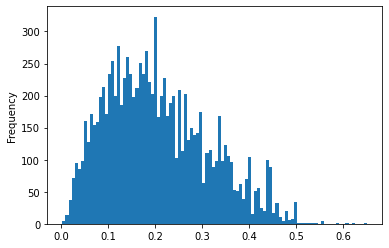

In [9]:
#
#                           loan amount
#  loan_income_ratio = -----------------------
#                          annual income 
#
#


# df["loan_income_ratio"] = ?
df["loan_income_ratio"] = df["loan_amnt"]/(df["annual_inc"]+1)




df["loan_income_ratio"].plot(kind="hist", bins=100)

In [10]:
# also, the label needs creation. This column should be = 1
# if the "loan_status" column is one of these values:
#
#     "Default", "In Grace Period", "Late (31-120 days)"
# 
# and = 0 otherwise
# df["target"] = ?



bad_loan = ["Default", 
            "In Grace Period", 
            "Late (31-120 days)"] # label value 1

good_loan = ["Fully Paid"] # label value 0

df["target"] = 0
df.loc[df["loan_status"].isin(bad_loan), "target"] = 1
df.drop(columns=["loan_status"], inplace=True)

fraction = df.target.mean()*100
print(f"fraction postitives in dataset: {fraction:.2f} %")

fraction postitives in dataset: 8.60 %


# 04 feature engineering


## 4.1 Scale numerical features

In [11]:
# 
# The task here is to scale all numerical features. You are free to 
# choose how you scale, some suggestions are minmax, standard 
# scaling (mean=0 and variance = 1) or similar
# 
#
# either you can do this by direct calculation (i.e df[col]-df[col].mean() etc )
# or by using a popular package called scikit-learn. Here, you may want to look 
# into the sklearn.preprocessing library 
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
#

df[numeric_cols] = ((df[numeric_cols]-df[numeric_cols].min())/
                    (df[numeric_cols].max() - df[numeric_cols].min()))

### OR ###

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


## 4.2 Onehot encode categorical columns

In [12]:
categorical_cols = ["term", "emp_length", "home_ownership", "purpose", "addr_state"]


# Now, the task is to one-hot encode the categorical columns. 
# for this, pd.get_dummies may be one useful function. Or you may want to look at the 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
# 
df_onehot = pd.get_dummies(df[categorical_cols])

### OR ###

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse =False)
df_onehot = ohe.fit_transform(df[categorical_cols])
df_onehot = pd.DataFrame(df_onehot, columns=ohe.get_feature_names(categorical_cols))

df = df.merge(df_onehot, left_index=True, right_index=True)
df.drop(columns=categorical_cols, inplace=True)

df.head()

,id,loan_amnt,emp_title,annual_inc,desc,title,nr_payment_remarks,nr_loans,loan_income_ratio,target,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,970906,0.394118,covanta energy,0.035184,Borrower added on 10/27/11 > purchace new ai...,personal,0.0,0.146552,0.191997,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,634792,0.435294,Unknown,0.015638,Borrower added on 12/20/10 > renovations and...,dukeberbatim,0.0,0.043103,0.438877,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16371827,0.323529,Sales Engineer,0.041700,Unknown,Debt consolidation,0.0,0.250000,0.136362,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45644356,0.911765,IT Manager,0.060245,Unknown,Credit card refinancing,0.0,0.387931,0.255998,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11946125,0.147059,store manager,0.024158,Unknown,Credit card refinancing,0.0,0.181034,0.113205,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4.3 Bonus - text features

### Helper functions

In [13]:
#
#
# In this section, you are supposed to make the text infomation more explicit for the ML model.
# The end goal is to make a numerical representation of the text data, and you are free to 
# choose whatever method you feel is suitable. 
# For example, you can read up on the TFIDF approach (Term Frequency-Inverse Document Freuency)
# (e.g. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
# 
# or use a USE, universal sentence encoder, such as examplified here: 
# https://tfhub.dev/google/universal-sentence-encoder/1
#
# However the method, you will need to clean the text data. This function may come in handy for this:
#
#
# def clean_text_values(df, rx='[^0-9a-zA-Z]+', rep = "_"):
#     """
#     clean text data in df, using regex specified in rx. 
#     Substitute with the value of argument "rep"
#     """
#         df = df.replace(
#             rx, rep, regex=True).astype(str)
        
#         return df
#
#  
# 
    

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')


def clean_text_values(df, rx='[^0-9a-zA-Z]+', rep = "_"):
    """
    clean text data in df, using regex specified in rx. 
    Substitute with the value of argument "rep"
    """
    df = df.replace(
        rx, rep, regex=True).astype(str).str.lower()

    return df

    
class DenseTfidfVectorizer(TfidfVectorizer):

    def transform(self, raw_documents, copy=True, id_str=''):
        X = super().transform(raw_documents, copy=copy)
        df = pd.DataFrame(X.toarray(), columns=self.get_feature_names())
        df.columns = [id_str + x.replace(' ', '_') for x in df.columns.values]
        return df

    def fit_transform(self, raw_documents, y=None, id_str=''):
        X = super().fit_transform(raw_documents, y=y)
        df = pd.DataFrame(X.toarray(), columns=self.get_feature_names())
        df.columns = [id_str + x.replace(' ', '_') for x in df.columns.values]
        return df
    
  

[nltk_data] Downloading package stopwords to /home/gurra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### clean text fields

In [14]:

textfield_1 = df["desc"] + ' ' + df["title"]
textfield_2 = df["emp_title"]

print(textfield_1.head(10))

textfield_1 = clean_text_values(textfield_1, rep=' ')
textfield_2 = clean_text_values(textfield_2, rep=' ')

textfield_1.head(10)

0      Borrower added on 10/27/11 > purchace new ai...
1      Borrower added on 12/20/10 > renovations and...
2                           Unknown Debt consolidation
3                      Unknown Credit card refinancing
4                      Unknown Credit card refinancing
5     558864 added on 10/17/09 > This loan will hel...
6                      Unknown Credit card refinancing
7      Borrower added on 12/15/11 > This loan will ...
8                             Unknown Home improvement
9                           Unknown Debt consolidation
dtype: object


0     borrower added on 10 27 11 purchace new aircr...
1     borrower added on 12 20 10 renovations and im...
2                           unknown debt consolidation
3                      unknown credit card refinancing
4                      unknown credit card refinancing
5     558864 added on 10 17 09 this loan will help ...
6                      unknown credit card refinancing
7     borrower added on 12 15 11 this loan will be ...
8                             unknown home improvement
9                           unknown debt consolidation
dtype: object

### define the most common words

In [15]:
  
    
stopWords = set(stopwords.words('english') + ["br", "unknown", "added", "borrower"])

stopWords

{'a',
 'about',
 'above',
 'added',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'borrower',
 'both',
 'br',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves'

### TFIDF-transformation of text fields

In [16]:
tf1 = DenseTfidfVectorizer(max_features=200, max_df=0.1, stop_words=stopWords, 
                          use_idf=True, binary=False, norm=None, ngram_range=(1,5))

df_text1 = tf1.fit_transform(textfield_1, id_str="Description_include_")
tf2 = DenseTfidfVectorizer(max_features=200, max_df=0.1, stop_words=stopWords, 
                          use_idf=True, binary=False, norm=None, ngram_range=(1,5))

df_text2 = tf2.fit_transform(textfield_2, id_str="Job_title_include_")


df_text2.head()

,Job_title_include_account,Job_title_include_account_manager,Job_title_include_accountant,Job_title_include_accounting,Job_title_include_administration,Job_title_include_administrative,Job_title_include_administrative_assistant,Job_title_include_administrator,Job_title_include_advisor,Job_title_include_agent,...,Job_title_include_usaf,Job_title_include_valley,Job_title_include_vice,Job_title_include_vice_president,Job_title_include_vp,Job_title_include_warehouse,Job_title_include_wells,Job_title_include_wells_fargo,Job_title_include_worker,Job_title_include_york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### merge all data into one dataframe

In [17]:

df = (
    df.merge(df_text1, left_index=True, right_index=True)
    .merge(df_text2, left_index=True, right_index=True)
)
df.drop(columns=["emp_title", "desc", "title"], inplace=True)

df.shape

(10000, 486)

In [18]:
df.head()

,id,loan_amnt,annual_inc,nr_payment_remarks,nr_loans,loan_income_ratio,target,term_ 36 months,term_ 60 months,emp_length_1 year,...,Job_title_include_usaf,Job_title_include_valley,Job_title_include_vice,Job_title_include_vice_president,Job_title_include_vp,Job_title_include_warehouse,Job_title_include_wells,Job_title_include_wells_fargo,Job_title_include_worker,Job_title_include_york
0,970906,0.394118,0.035184,0.0,0.146552,0.191997,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,634792,0.435294,0.015638,0.0,0.043103,0.438877,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16371827,0.323529,0.041700,0.0,0.250000,0.136362,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45644356,0.911765,0.060245,0.0,0.387931,0.255998,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11946125,0.147059,0.024158,0.0,0.181034,0.113205,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 05 write back table to a database 

In [19]:

#
# Now the task is to upload the prepared data to the database. 
# for this we have a postgres db hosted on AWS RDS
# Below is the credentials you need to connect. now the task is to upload 
# the table to the "de_course" database ("public" schema). 
# You may use the pd.to_sql command with the egine directly, 
# however you may find faster options in the link below...
# https://stackoverflow.com/questions/23103962/how-to-write-dataframe-to-postgres-table
#
# # NOTE: Name the table "prepared_data_{NAME}" where the name is you name.



port='5432' 
user= "postgres"
password= "bizware_training_2020"
server_url = "data-engineering.c83yueos1s3z.eu-north-1.rds.amazonaws.com"
db = "de_course"
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{server_url}:{port}/{db}')



def postgres_insert_copy(table, conn, keys, data_iter):
    # gets a DBAPI connection that can provide a cursor
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)

        columns = ', '.join('"{}"'.format(k) for k in keys)
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name

        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
            table_name, columns)
        cur.copy_expert(sql=sql, file=s_buf)

df.to_sql('processed_data_gustav_eklund', engine, method=postgres_insert_copy, if_exists="replace")
